In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import FITS_tools
from astropy.io import fits
import astropy.wcs as pywcs
import sep
from tqdm import tqdm
import pcmdpy as ppy
import pyregion
%matplotlib inline

# Center PHAT data

In [2]:
def load_from_fits(f):
    hdu_list = fits.open(f)
    im = hdu_list['sci'].data
    h = hdu_list['sci'].header
    wcs = pywcs.WCS(h, fobj=hdu_list)
    wcs.naxis2 = h['naxis2']
    wcs.naxis1 = h['naxis1']
    return im, h, wcs

In [3]:
def update_header(h1, h2):
    h3 = h1.copy()
    for k in ['NAXIS1', 'NAXIS2', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2', 
             'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 'ORIENTAT', 'RA_APER', 'DEC_APER']:
        h3[k] = h2[k]
    return h2

In [4]:
def shift_fits(file_1, file_2, output_file=None):
    im1, h1, wcs1 = load_from_fits(file_1)
    im2, h2, wcs2 = load_from_fits(file_2)
    print('beginning transformation')
    new_im = FITS_tools.hcongrid.hastrom(im1, wcs1, wcs2, preserve_bad_pixels=True)
    print('transformation complete')
    new_h = update_header(h1, h2)
    hdu = fits.ImageHDU(data=new_im, header=new_h)
    if output_file is not None:
        print('saving result')
        hdu.writeto(output_file, overwrite=True)
    return hdu

In [5]:
# %%time
# Takes tens of minutes
# shift_fits('../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f475w_v1_drz.fits',
#            '../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f814w_v1_drz.fits',
#         output_file='../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f475w_v1_drz_ALIGNED.fits')

In [6]:
# %%time
# Takes tens of minutes
# shift_fits('../data/m31/raw/hlsp_phat_hst_acs-wfc_12105-m31-b06_f475w_v1_drz.fits',
#            '../data/m31/raw/hlsp_phat_hst_acs-wfc_12105-m31-b06_f814w_v1_drz.fits',
#         output_file='../data/m31/raw/hlsp_phat_hst_acs-wfc_12105-m31-b06_f475w_v1_drz_ALIGNED.fits')

# Extract PCMDs

In [7]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)

In [8]:
bulge_charlie = np.loadtxt('../data/m31/pcmds/m31_old_r1.pcmd', unpack=True)

bulge_f814w = fits.open('../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f814w_v1_drz.fits')
bulge_f475w = fits.open('../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f475w_v1_drz_ALIGNED.fits')
wht_bulge_f475w = fits.open('../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f475w_v1_drz.fits')['WHT'].data

In [9]:
disk_charlie = np.loadtxt('../data/m31/pcmds/m31_old_r2.pcmd', unpack=True)

disk_f814w = fits.open('../data/m31/raw/hlsp_phat_hst_acs-wfc_12105-m31-b06_f814w_v1_drz.fits')
disk_f475w = fits.open('../data/m31/raw/hlsp_phat_hst_acs-wfc_12105-m31-b06_f475w_v1_drz_ALIGNED.fits')
wht_disk_f475w = fits.open('../data/m31/raw/hlsp_phat_hst_acs-wfc_12105-m31-b06_f475w_v1_drz.fits')['WHT'].data

In [13]:
def make_pcmd(region_file, hdu_f814w, hdu_f475w, wht_f475w):
    cutouts = pyregion.open(region_file).as_imagecoord(header=hdu_f814w[0].header)
    mask = np.ones(hdu_f814w[1].shape, dtype=bool)
    mask_wht = np.ones(wht_f475w.shape, dtype=bool)
    for i in range(len(cutouts)):
        mask = mask & cutouts[i:i+1].get_mask(shape=hdu_f814w[1].shape)
        mask_wht = mask_wht & cutouts[i:i+1].get_mask(shape=wht_f475w.shape)
    mag_F814W = f[0].counts_to_mag(hdu_f814w['SCI'].data[mask] * f[0]._exposure, mag_system='vega')
    mag_F475W = f[1].counts_to_mag(hdu_f475w['SCI'].data[mask] * f[1]._exposure, mag_system='vega')
    pcmd = np.array([mag_F814W, mag_F475W - mag_F814W])
    
    w = np.where(mask)
    xlims = [min(w[1]), max(w[1])]
    ylims = [min(w[0]), max(w[0])]
    
    exp_F814W = np.median(hdu_f814w['WHT'].data[mask])
    exp_F475W = np.median(wht_f475w[mask_wht])

    return pcmd, xlims, ylims, exp_F814W, exp_F475W

In [15]:
def save_pcmd(pcmd, filename, region_desc='', xcyc=None, rlims=None, xlims=None, ylims=None, exp_F814W=None, exp_F475W=None):
    header = region_desc + '\n'
    if xcyc is not None:
        header += 'xc,yc = {:.0f},{:.0f}\n'.format(xcyc[0], xcyc[1])
    if rlims is not None:
        header += '{:.0f} < r < {:.0f}\n'.format(rlims[0], rlims[1])
    if xlims is not None:
        header += '{:.0f} < x < {:.0f}\n'.format(xlims[0], xlims[1])
    if ylims is not None:
        header += '{:.0f} < y < {:.0f}\n'.format(ylims[0], ylims[1])
    if exp_F814W is not None:
        header += 'F814W Exposure ~ {:.0f} sec\n'.format(exp_F814W)
    if exp_F814W is not None:
        header += 'F475W Exposure ~ {:.0f} sec\n'.format(exp_F475W)
    header += 'Effective Nim ~ {:.0f} pix\n'.format(np.sqrt(len(pcmd[0])))
    header += 'Vega apparent mags\n' + 'Imag Gmag-Imag\n' + 'F814W F475W-F814W'
    np.savetxt(filename, pcmd.T, header=header, fmt='%.5f')

In [16]:
pcmds = {}
xlims = {}
ylims = {}
exp_F814W = {}
exp_F475W = {}

xcyc = [10150, 6370]
rlims = {
    'bulge_1': [6200, 6250],
    'bulge_2': [2000, 2100],
    'bulge_3': [1300, 1400],
}

for i in tqdm(range(1, 4)):
    k = 'bulge_{:d}'.format(i)
    pcmds[k], xlims[k], ylims[k], exp_F814W[k], exp_F475W[k] = make_pcmd('../data/m31/masks/bulge_newregion_{:d}.reg'.format(i),
                                                                          bulge_f814w, bulge_f475w, wht_bulge_f475w)
for i in tqdm(range(1, 11)):
    k = 'disk_{:d}'.format(i)
    pcmds[k], xlims[k], ylims[k], exp_F814W[k], exp_F475W[k] = make_pcmd('../data/m31/masks/disk_newregion_{:d}.reg'.format(i),
                                                                         disk_f814w, disk_f475w, wht_disk_f475w)
    rlims[k] = None

 20%|██        | 2/10 [00:32<02:08, 16.01s/it]

KeyboardInterrupt: 

In [66]:
print('Effective Nim:')
for k, pcmd in pcmds.items():
    print(k, '{:.0f}'.format(np.sqrt(pcmd.shape[1])))

Effective Nim:
bulge_1 306
bulge_2 339
bulge_3 350
disk_1 381
disk_2 381
disk_3 381
disk_4 381
disk_5 381
disk_6 381
disk_7 381
disk_8 381
disk_9 381
disk_10 706


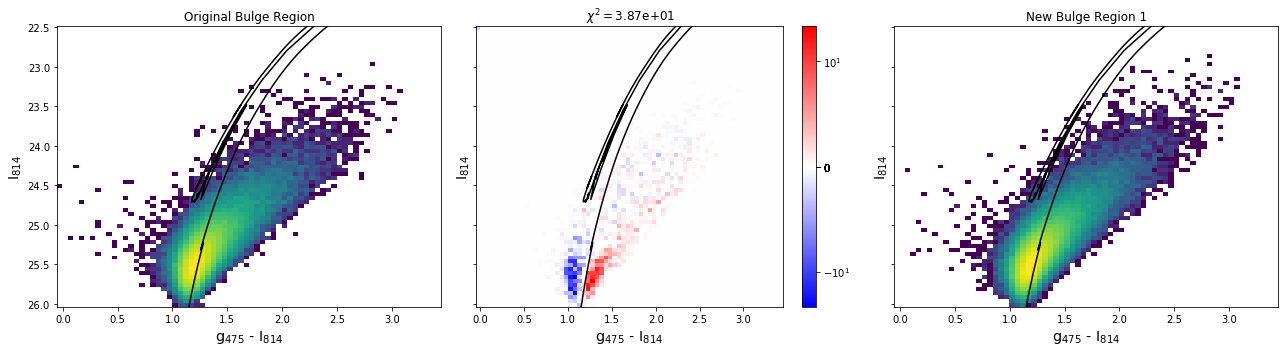

In [67]:
fig, axes = plt.subplots(ncols=3, figsize=(18,5), sharex=True, sharey=True)
_, bins, _ = ppy.plotting.plot_pcmd(bulge_charlie, ax=axes[0], title='Original Bulge Region');
ppy.plotting.plot_pcmd_residual(bulge_charlie, pcmds['bulge_1'], ax=axes[1], bins=bins, like_mode=2);
plt.colorbar()
_, bins, _ = ppy.plotting.plot_pcmd(pcmds['bulge_1'], ax=axes[2], bins=bins, title='New Bulge Region 1');
for ax in axes:
    ppy.plotting.plot_isochrone(iso_model, axes=ax, mag_system='ab', dmod=24.42)
plt.tight_layout()

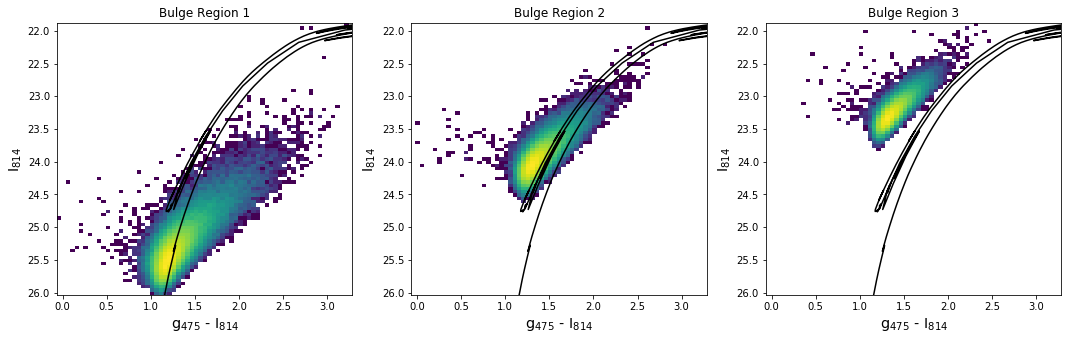

In [68]:
fig, axes = plt.subplots(ncols=3, figsize=(18,5))
_, bins, _ = ppy.plotting.plot_pcmd(pcmds['bulge_1'], title='Bulge Region 1', ax=axes[0]);
ppy.plotting.plot_pcmd(pcmds['bulge_2'], title='Bulge Region 2', bins=bins, ax=axes[1]);
ppy.plotting.plot_pcmd(pcmds['bulge_3'], title='Bulge Region 3', bins=bins, ax=axes[2]);
for ax in axes:
    ppy.plotting.plot_isochrone(iso_model, dmod=24.47, mag_system='ab', axes=ax)


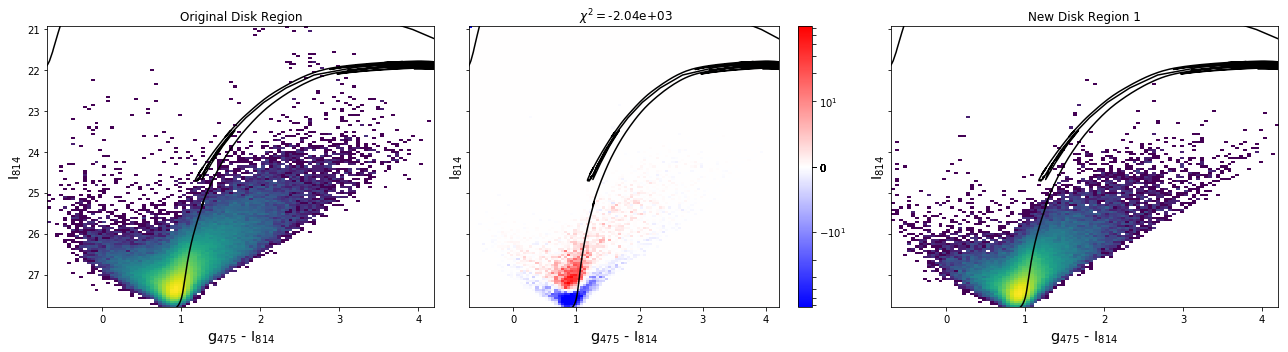

In [69]:
fig, axes = plt.subplots(ncols=3, figsize=(18,5), sharex=True, sharey=True)
_, bins, _ = ppy.plotting.plot_pcmd(disk_charlie, ax=axes[0], title='Original Disk Region');
ppy.plotting.plot_pcmd_residual(disk_charlie, pcmds['disk_1'], ax=axes[1], bins=bins, like_mode=2);
plt.colorbar()
_, bins, _ = ppy.plotting.plot_pcmd(pcmds['disk_1'], ax=axes[2], bins=bins, title='New Disk Region 1');
for ax in axes:
    ppy.plotting.plot_isochrone(iso_model, axes=ax, mag_system='ab', dmod=24.42)
plt.tight_layout()

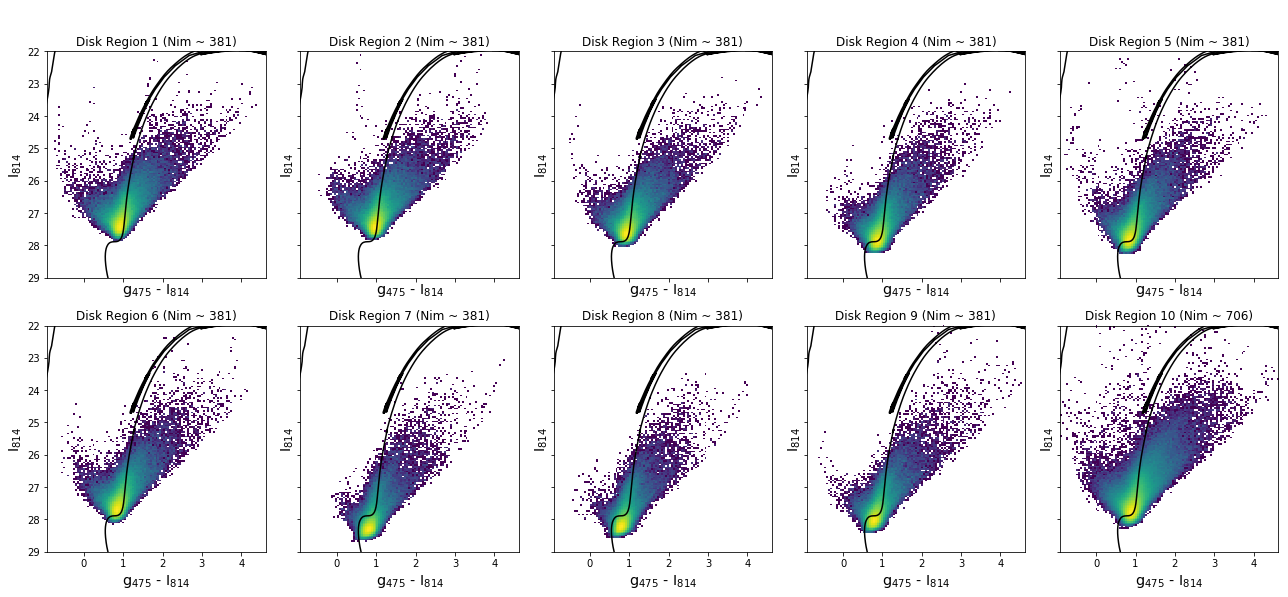

In [71]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(18, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    k = 'disk_{:d}'.format(i+1)
    ppy.plotting.plot_pcmd(pcmds[k], ax=ax, title='Disk Region {:d} (Nim ~ {:.0f})'.format(i+1, np.sqrt(len(pcmds[k][0]))))
    ppy.plotting.plot_isochrone(iso_model, axes=ax, mag_system='ab', dmod=24.42)
axes[0,0].set_ylim([29, 22])
plt.tight_layout()

# Save PCMDs

In [72]:
# 2x Summer Exposures: F814W = 3040, F475W = 3440
# 2x Winter Exposures: F814W = 3430, F475W = 3800

In [73]:
exp_F814W

{'bulge_1': 3018.0269,
 'bulge_2': 3411.0854,
 'bulge_3': 3458.844,
 'disk_1': 3439.4395,
 'disk_10': 3059.2222,
 'disk_2': 3431.9458,
 'disk_3': 3380.148,
 'disk_4': 3039.2544,
 'disk_5': 3036.6975,
 'disk_6': 3386.4946,
 'disk_7': 3033.3818,
 'disk_8': 3022.4111,
 'disk_9': 3080.0989}

In [74]:
exp_F475W

{'bulge_1': 3421.4558,
 'bulge_2': 3792.3118,
 'bulge_3': 3852.9062,
 'disk_1': 3804.8535,
 'disk_10': 3466.331,
 'disk_2': 3796.9292,
 'disk_3': 3784.7373,
 'disk_4': 3440.2964,
 'disk_5': 3429.691,
 'disk_6': 3783.0732,
 'disk_7': 3423.2769,
 'disk_8': 3411.1162,
 'disk_9': 3476.4128}

In [75]:
seasons = {k:'summer' if np.abs(exp_F814W[k] - 3040) <= 100 else 'winter' for k in exp_F814W.keys()}
seasons

{'bulge_1': 'summer',
 'bulge_2': 'winter',
 'bulge_3': 'winter',
 'disk_1': 'winter',
 'disk_10': 'summer',
 'disk_2': 'winter',
 'disk_3': 'winter',
 'disk_4': 'summer',
 'disk_5': 'summer',
 'disk_6': 'winter',
 'disk_7': 'summer',
 'disk_8': 'summer',
 'disk_9': 'summer'}

In [76]:
for k, s in seasons.items():
    if s == 'winter':
        assert np.abs(exp_F475W[k] - 3800) <= 100
    else:
        assert np.abs(exp_F475W[k]- 3440) <= 100
print('All Good')

All Good


In [77]:
n_summer = 1
n_winter = 1
for k in pcmds.keys():
    reg, i = k.split('_')
    reg = reg.capitalize()
    desc = 'New {:s} Region {:s}'.format(reg, i)
    print(desc)
    if seasons[k] == 'winter':
        fname = '../data/m31/pcmds/m31_winter_r{:d}.pcmd'.format(n_winter)
        e_f814w = 3430
        e_f475w = 3800
        n_winter += 1
    else:
        fname = '../data/m31/pcmds/m31_summer_r{:d}.pcmd'.format(n_summer)
        e_f814w = 3040
        e_f475w = 3440
        n_summer += 1
    if 'bulge' in k:
        centers = xcyc
    else:
        centers = None
    save_pcmd(pcmds[k], fname,
              region_desc=desc,
              xcyc=centers,
              rlims=rlims[k],
              xlims=xlims[k],
              ylims=ylims[k],
              exp_F814W=e_f814w,
              exp_F475W=e_f475w
             )

New Bulge Region 1
New Bulge Region 2
New Bulge Region 3
New Disk Region 1
New Disk Region 2
New Disk Region 3
New Disk Region 4
New Disk Region 5
New Disk Region 6
New Disk Region 7
New Disk Region 8
New Disk Region 9
New Disk Region 10
